How to use this notebook: 
* Areas to modify are marked with !!CHANGE!!  

Parameters to tune:
* Outlier trimming cutoffs
* Optimal Number of Clusters
* Decision Tree Depth

# Data Cleaning

In [ ]:
# package imports
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
import datetime
%matplotlib inline 
sns.set(color_codes=True)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.tree.export import export_text
import scipy.cluster.hierarchy as shc
from math import sqrt
import umap
import matplotlib.patheffects as path_effects

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# mounting gDrive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# !!CHANGE!!: filepath to csv
# import from drive
data = pd.read_csv("/content/gdrive/My Drive/Year 4/Capstone/Capstone Data/Vehicle_Parts_Tires.csv") 

In [ ]:
data.head()

CLSFD_USER_ID  ... total_ftr_spend
0  20000000000000698  ...             NaN
1  20000000000002106  ...             NaN
2  20000000000002154  ...            4.99
3  20000000000002342  ...             NaN
4  20000000000002373  ...            9.95

[5 rows x 22 columns]

In [ ]:
# set index
data = data.set_index(['CLSFD_USER_ID'])

# add new column for number of days since last post
data['first_post_dt'] = pd.to_datetime(data['first_post_dt'])
data['first_post_dt'] =  (datetime.datetime(2020,1,27) - data['first_post_dt']).apply(lambda x:x.days)

data['last_post_dt'] = pd.to_datetime(data['last_post_dt'])
data['last_post_dt'] =  (datetime.datetime(2020,1,27) - data['last_post_dt']).apply(lambda x:x.days)

# # add new column for number of days since first reply
data['first_reply_dt'] = pd.to_datetime(data['first_reply_dt'])
data['first_reply_dt'] =  (datetime.datetime(2020,1,27) - data['first_reply_dt']).apply(lambda x:x.days)

# trim all users who haven't posted in the last year
data = data[data['last_post_dt'] < 366]

# fill all nas with 0
data = data.fillna(value=0)

# convert email domain into [0,1] using factorize
data['email_domain']=  pd.factorize(data['email_domain'])[0]

# add new column for ratio of buy:sell activity
data['buy_sell_ratio'] = (data['replies_sent_to_seller']+0.0)/(data['total_ads_posted']+0.0)

# * replies sent/day  
data['replies_sent_to_seller'] = (data['replies_sent_to_seller']+0.0)/(data['first_reply_dt']+0.0)

# * replies received/post  
data['replies_received_from_buyers'] = (data['replies_received_from_buyers']+0.0)/(data['total_ads_posted']+0.0)

# * connections/post  
data['cnctns'] = (data['cnctns']+0.0)/(data['total_ads_posted']+0.0)

# avg spend/ad
data['avg_spend_per_ad'] = (data['total_ftr_spend']+0.0)/(data['total_ads_posted']+0.0)

# channel ratio
data['web_posts'] = (data['web_posts']+0.0)/(data['total_ads_posted']) 
data['mobile_web_posts'] = (data['mobile_web_posts']+0.0)/(data['total_ads_posted']) 
data['app_posts'] = (data['app_posts']+0.0)/(data['total_ads_posted']) 

# turn ads_posted to ads posted per day 
data['total_ads_posted'] = (data['total_ads_posted']+0.0)/(data['first_post_dt']+0.0)

# fill nas with 0
data = data.fillna(value=0)

# drop category bc they're all the same
data = data.drop(columns=["custom_cat"])

data.shape

(778356, 22)

## Trimming Outliers

In [ ]:
# !!CHANGE!!
# Conduct outlier trim according to inspection of 5 main variables:  
#   1) total_ads_posted
#   2) replies_sent_to_seller
#   3) replies_received_from_buyers
#   4) total_inventory_value
#   5) total_ftr_spend

In [ ]:
data.quantile(np.linspace(0, 1, 101))

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


email_domain  total_ads_posted  ...  buy_sell_ratio  avg_spend_per_ad
0.00           0.0          0.001940  ...        0.000000          0.000000
0.01           0.0          0.002134  ...        0.000000          0.000000
0.02           0.0          0.002398  ...        0.000000          0.000000
0.03           0.0          0.002639  ...        0.000000          0.000000
0.04           0.0          0.002882  ...        0.000000          0.000000
...            ...               ...  ...             ...               ...
0.96           0.0          0.063731  ...        9.500000          0.000000
0.97           1.0          0.080043  ...       11.333333          1.105670
0.98           1.0          0.111313  ...       14.666667          3.950000
0.99           1.0          0.211648  ...       21.500000          9.875000
1.00           1.0               NaN  ...      801.000000       1205.396667

[101 rows x 20 columns]

In [ ]:
# First, trim on total_ads_posted
# Get the quantile value that we desire

percent = 0.01

q_high = data["total_ads_posted"].quantile(1-percent)
q_low = data["total_ads_posted"].quantile(percent)

data_filt = data[(data["total_ads_posted"] < q_high) & (data["total_ads_posted"] > q_low)]

data_filt.shape

(762753, 22)

In [ ]:
# Do the same for the rest
# Replies sent to selllers (only on high values b/c there are too many 0's...)

percent = 0.02

q_high = data_filt["replies_sent_to_seller"].quantile(1-percent)

data_filt2 = data_filt[(data_filt["replies_sent_to_seller"] < q_high)]

data_filt2.shape

(747496, 22)

In [ ]:
# Now, let's do a 0.5% trim on the upper end of total_inventory_value
percent = 0.005

q_high = data_filt2["total_inventory_value"].quantile(1-percent)

data_filt3 = data_filt2[(data_filt2["total_inventory_value"] < q_high)]

data_filt3.shape

(743758, 22)

In [ ]:
# Now, let's do a 1% trim on the upper end of avg_price, 1% trim on the lower end of avg_price
percent = 0.005

q_high = data["avg_price"].quantile(1-percent)
q_low = data["avg_price"].quantile(percent)

data_filt4 = data_filt3[(data["avg_price"] < q_high) & (data["avg_price"] > q_low)]

data_filt4.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(157363, 22)

In [ ]:
# Now, let's do a 0.5% trim on the upper end of total_ftr_spend
percent = 0.005

q_high = data_filt4["total_ftr_spend"].quantile(1-percent)

data_filt5 = data_filt4[(data_filt4["total_ftr_spend"] < q_high)]

data_filt5.shape

(156576, 22)

In [ ]:
# final check for outliers (adjust filtering if values are still crazy)
df_copy = data_filt5
data_filt5.quantile(np.linspace(0, 1, 101))

In [ ]:
# drop unneeded columns
data_filt5 = data_filt5.drop(["fsb_ownr", "fsb_delr", "account_cre_date", "first_post_dt", "last_reply_dt","first_reply_dt", "last_post_dt","web_posts", "mobile_web_posts", "app_posts", "total_ftr_spend"], axis='columns')
# clean infinite values
data_filt5 = data_filt5.replace([np.inf, -np.inf], 0)

In [ ]:
# rearrange columns
cols = data_filt5.columns.tolist()
cols = cols[-2:] + cols[:-2]
data_filt5 = data_filt5[cols]

## Feature Weighting 

In [ ]:
data_filt5.shape

(156576, 11)

In [ ]:
# !!CHANGE!! according to number of columns
# weighting of 2.6  
main_columns = 11 # this should not change
buy_sell_columns = 0

w = 1/(main_columns*2.6+buy_sell_columns)

weights = [2.6*w for i in range(main_columns)] + [w for i in range(buy_sell_columns)]

# Clustering

## Determine # of clusters

In [ ]:
# helper function to get cluster distribution
def get_cluster_dist(cluster_vec, num_clusters):
  cluster_vec_copy = list(cluster_vec)
  clust_dist = []

  for i in range(num_clusters):
    clust_dist.append(round(cluster_vec_copy.count(i)/len(cluster_vec_copy), 3))

  return clust_dist

In [ ]:
# tune clusters with variable seeds
# note: this part will take the longest to run
# if you find that the outputs with different random seeds are wildly inconsistent, consider looking at your outlier trimming
random_seeds = 5

# create a dictionary
db_scores = {}
sil_scores = {}

#Fill this in with your own set of parameters you want to try
parameters = [2,3,4,5,6]

for j in range(random_seeds):
  print("Random Seed: ", j)
  db_scores[j] = list()
  sil_scores[j] = list()
  for i in parameters:
    e_sample_vf = data_filt5.sample(n=45000, random_state=j)

    # take the norm
    scaler=StandardScaler()
    e_sample_norm_vf = scaler.fit_transform(e_sample_vf)

    # weighting
    for k in range(len(weights)):
      e_sample_norm_vf[k] = e_sample_norm_vf[k]*weights[k]

    # Prep and run the model
    mod = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')  
    clusters = mod.fit_predict(e_sample_norm_vf)

    db = round(sklearn.metrics.davies_bouldin_score(e_sample_norm_vf, clusters), 2)
    db_scores[j].append(db)
    sil = round(sklearn.metrics.silhouette_score(e_sample_norm_vf, clusters), 2)
    sil_scores[j].append(sil)

    # Print out some relevant pieces of information
    print("DB Score with ", i, " clusters: ", db)
    print("Silhouette Score with ", i, " clusters: ", sil)
    print("Cluster Distribution: ", get_cluster_dist(clusters, i))
  
plt.figure(1)
for i in range(random_seeds):
  plt.plot(parameters, db_scores[i])

plt.figure(2)
for i in range(random_seeds):
  plt.plot(parameters, sil_scores[i])

## Optimal Configuration

In [ ]:
# !!CHANGE!! 
# pick the best seed and number of clusters from previous testing
e_sample_vf = data_filt5.sample(n=50000, random_state=3)

# take the norm
scaler=StandardScaler()
e_sample_norm_vf = scaler.fit_transform(e_sample_vf)

# weighting
for k in range(len(weights)):
  e_sample_norm_vf[k] = e_sample_norm_vf[k]*weights[k]

# Prep and run the model
# 4 clusters was the most consistent
mod = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
clusters = mod.fit_predict(e_sample_norm_vf)

In [ ]:
round(sklearn.metrics.davies_bouldin_score(e_sample_norm_vf, clusters), 2)

1.92

In [ ]:
round(sklearn.metrics.silhouette_score(e_sample_norm_vf, clusters), 2)

0.31

In [ ]:
print("Cluster Distribution: ", get_cluster_dist(clusters, 3))

Cluster Distribution:  [0.193, 0.036, 0.771]


# Decision Trees

## Decision Tree Tuning

In [ ]:
norm_df = pd.DataFrame(e_sample_norm_vf)

norm_df_ward = pd.DataFrame(e_sample_norm_vf)
norm_df_ward.insert(1, 'Cluster', clusters, allow_duplicates=True)


With depth of  2  layers, ward has accuracy of:  0.89726

With depth of  3  layers, ward has accuracy of:  0.92594

With depth of  4  layers, ward has accuracy of:  0.93514

With depth of  5  layers, ward has accuracy of:  0.94388

With depth of  6  layers, ward has accuracy of:  0.95264


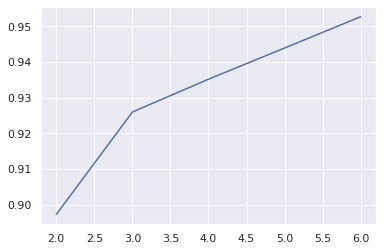

In [ ]:
depths = [2, 3, 4, 5, 6]
ward_acc = []

for param in depths:
  estimator_ward = DecisionTreeClassifier(max_depth=param)
  estimator_ward.fit(e_sample_vf, norm_df_ward['Cluster'])
  accuracy = estimator_ward.score(e_sample_vf, norm_df_ward['Cluster'])
  ward_acc.append(accuracy)

for i in range(len(depths)):
  print("\nWith depth of ", depths[i], " layers, ward has accuracy of: ", ward_acc[i])

plt.figure(1)
plt.plot(depths, ward_acc)

## Final Decision Tree

In [ ]:
# !! CHANGE !! optimal max depth
# Plot final decision tree
estimator_ward = DecisionTreeClassifier(max_depth=3)
estimator_ward.fit(e_sample_vf, norm_df_ward['Cluster'])
cnames=list(map(str,list(range(7))))
graph = Source(tree.export_graphviz(estimator_ward, out_file=None
   , feature_names=e_sample_vf.columns, class_names=cnames 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

In [ ]:
# text representation
r = export_text(estimator_ward, feature_names=list(e_sample_vf.columns), show_weights=True)
print(r)

array([ 9650.,  1800., 38550.,     0.,     0.])

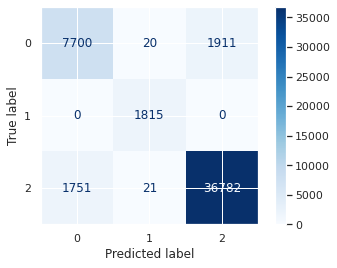

In [ ]:
#confusion matrix

print(sklearn.metrics.plot_confusion_matrix(estimator_ward,e_sample_vf, norm_df_ward['Cluster'],cmap=plt.cm.Blues,values_format=''))
np.multiply(get_cluster_dist(norm_df_ward['Cluster'],5),50000)

# Post-Hoc Analysis

## PCA

In [ ]:
pca = PCA(1) # 100% of the variance explained
pca.fit(norm_df)
T = pca.transform(norm_df)
components = pd.DataFrame(pca.components_, columns = e_sample_vf.columns)

components

In [ ]:
#!!CHANGE!! according to the number of components in the PCA
def get_important_features(transformed_features, components_, columns):
    """
    This function will return the most "important" 
    features so we can determine which have the most
    effect on multi-dimensional scaling
    """
    num_columns = len(columns)
    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    vector1 = components_[0] * max(transformed_features[:,0])
    # vector2 = components_[1] * max(transformed_features[:,1])
    # vector3 = components_[2] * max(transformed_features[:,2])
    # vector4 = components_[3] * max(transformed_features[:,3])

    # Sort each column by its length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : sqrt(vector1[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print ("Features by importance:", important_features)

get_important_features(T, pca.components_, e_sample_vf.columns.values)

Features by importance: [(34.56279721051416, 'cnctns'), (33.307714832932845, 'replies_received_from_buyers'), (12.43654706783717, 'buy_sell_ratio'), (11.122799687006953, 'replies_sent_to_seller'), (10.555523617331103, 'cnvrstn_depth'), (9.904280028141752, 'avg_price'), (7.805705450895274, 'total_inventory_value'), (7.154254363410709, 'avg_ad_duration_days'), (3.6453358433233993, 'avg_spend_per_ad'), (3.3685360191132436, 'total_ads_posted'), (3.234468962257152, 'email_domain')]


## Data Visualization

In [ ]:
umapresults = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2).fit_transform(e_sample_norm_vf)
umapdf=pd.DataFrame()
umapdf['umapone'] = umapresults[:,0]
umapdf['umaptwo'] = umapresults[:,1]

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/utils.py", line 409:
@numba.njit(parallel=True

In [ ]:
# Utility function to visualize the outputs of PCA and t-SNE
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # # add the labels for each digit corresponding to the label
    txts = []

    # for i in range(num_classes):

    #     # Position of each label at median of data points.

    #     xtext, ytext = np.median(x[colors == i, :], axis=0)
    #     txt = ax.text(xtext, ytext, str(i), fontsize=24)
    #     txt.set_path_effects([
    #         path_effects.Stroke(linewidth=5, foreground="w"),
    #         path_effects.Normal()])
    #     txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 [])

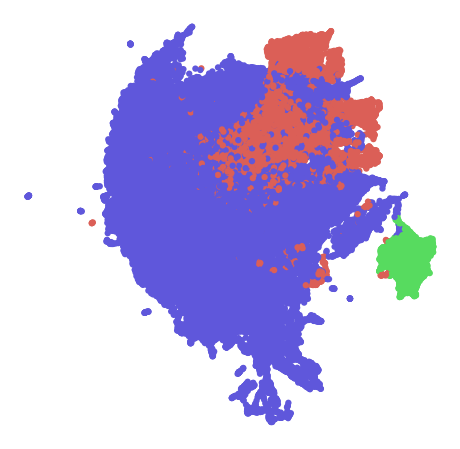

In [ ]:
fashion_scatter(umapdf.values,norm_df_ward.Cluster.values)

## Data Visualisation - Seller Flag Only

In [ ]:
data_filt5.head()

In [ ]:
# drop unneeded columns
data_filt6 = df_copy.drop(["fsb_ownr","web_posts", "mobile_web_posts","app_posts", "account_cre_date", "first_post_dt", "last_reply_dt","first_reply_dt", "last_post_dt"], axis='columns') # "fsb_delr"
# clean infinite values
data_filt6 = data_filt6.replace([np.inf, -np.inf], 0)

# sample with same seed as above and take the norm
sample_fsb = pd.DataFrame(data_filt6.sample(n=50000, random_state=3))

sample_fsb_labels = sample_fsb["fsb_delr"]
sample_fsb_nolabels = sample_fsb.drop(["fsb_delr"],axis='columns')

# take the norm
scaler=StandardScaler()
sample_fsb_nolabels = scaler.fit_transform(sample_fsb_nolabels)

In [ ]:
# UMAP
umapresults2 = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2).fit_transform(sample_fsb_nolabels)
umapdf=pd.DataFrame()

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


In [ ]:
umapdf['umapone'] = umapresults2[:,0]
umapdf['umaptwo'] = umapresults2[:,1]

(<Figure size 576x576 with 1 Axes>,
 [])

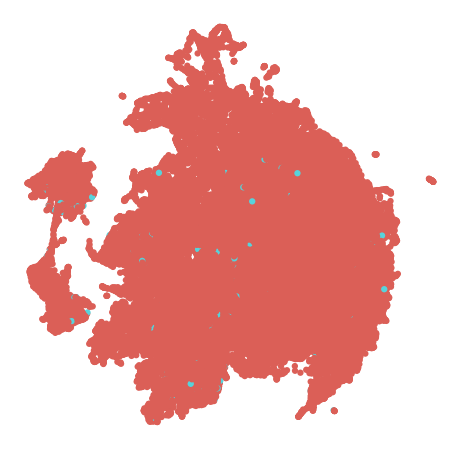

In [ ]:
fashion_scatter(umapdf.values,sample_fsb_labels.values)

## Boxplots

In [ ]:
# import pandas
import pandas as pd
# import matplotlib
import matplotlib.pyplot as plt
# import seaborn
import seaborn as snse
%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
# add back in the "mobile_web_posts, app_posts, web_posts, fsb_"
cols_add = ["mobile_web_posts", "app_posts", "web_posts", "fsb_delr", "fsb_ownr"]

data_filt6 = df_copy[cols_add]

# clean infinite values
data_filt6 = data_filt6.replace([np.inf, -np.inf], 0)

# sample with same seed as above and take the norm
sample_fsb = pd.DataFrame(data_filt6.sample(n=50000, random_state=3))

In [ ]:
sample_all_cols = pd.concat([sample_fsb, e_sample_vf], axis=1, join='inner')

In [ ]:
# insert selena's code here
plt_df = pd.DataFrame(sample_all_cols,  columns = sample_all_cols.columns)
plt_df.insert(1, 'Cluster', clusters, allow_duplicates=True)
plt_df.Cluster.unique()

array([2, 0, 1])

In [ ]:
plt_df.columns

Index(['mobile_web_posts', 'Cluster', 'app_posts', 'web_posts', 'fsb_delr',
       'fsb_ownr', 'buy_sell_ratio', 'avg_spend_per_ad', 'email_domain',
       'total_ads_posted', 'replies_sent_to_seller',
       'replies_received_from_buyers', 'cnctns', 'cnvrstn_depth',
       'avg_ad_duration_days', 'total_inventory_value', 'avg_price'],
      dtype='object')

In [ ]:
# code for generating list of features to plot against, allowable arguments: "pca", "general" for list_type

def get_feat_list(list_type):

  if list_type == 'pca':

    # get top 10 features ranked by pca importance
    pca_df = components.transpose().reset_index().sort_values(by=0, ascending = False).reset_index()
    top_10_pca_list = list(pca_df['index'].unique())[:10]
    print('Top 10 features by PCA are: ', top_10_pca_list)

    feat_list = top_10_pca_list

  elif list_type == 'general':
    
    # all columns 
    gen_list = list(plt_df.columns)
    
    feat_list = gen_list

  else: 
    return none 

  return feat_list

In [ ]:
def plt_box(feat_list, df):

  for i in feat_list:
    sns.boxplot(y = i, x = 'Cluster', data = df, showfliers = False)
    plt.show()


# Violin plot - show distribution 
def plt_violin(feat_list, df):

  for i in feat_list:
    sns.violinplot(y = i, x = 'Cluster', data = df, showfliers = False)
    plt.show()

In [ ]:
# plot all columns
feat_list = get_feat_list('general')
plt_box(feat_list, plt_df)
plt_violin(feat_list, plt_df)

In [ ]:
# plot top 10 pca columns
feat_list = get_feat_list('pca')
plt_violin(feat_list, plt_df)

## Subcategory reply/post

Get concentration of posts in subcategories

In [ ]:
post_col = [s for s in list(plt_df.columns) if "ads_posted" in s]
post_col.pop(0)  #remove "total_ads_posted" column

reply_col = [s for s in list(plt_df.columns) if "replies_to_seller" in s]

In [ ]:
def calc_ratio(df2, col_list, denom_col):

  df = df2.copy()
  new_cols = []

  for i in range(0, len(post_col)):
    
    new_col_name = 'percent_' + col_list[i]  
    new_cols.append(new_col_name)

    df[new_col_name] = df[col_list[i]]/df[denom_col]

  return df, new_cols

In [ ]:
sub_df, new_post_cols = calc_ratio(plt_df, post_col, 'total_ads_posted')
sub_df, new_reply_cols = calc_ratio(sub_df, reply_col, 'replies_sent_to_seller')

In [ ]:
plt_box(new_post_cols, sub_df)

In [ ]:
plt_box(new_reply_cols, sub_df)

## Averages per cluster

In [ ]:
post_col = [s for s in list(plt_df.columns) if "ads_posted" in s]
post_col.pop(0)  #remove "total_ads_posted" column
reply_col = [s for s in list(plt_df.columns) if "replies_to_seller" in s]

perc_df,new_post_cols = calc_ratio(plt_df, post_col, 'total_ads_posted')
perc_df = perc_df[new_post_cols]

rply_df, new_reply_cols = calc_ratio(sub_df, reply_col, 'replies_sent_to_seller')
rply_df = rply_df[new_reply_cols]

In [ ]:
df = pd.concat([perc_df, rply_df, plt_df], axis=1, join='inner')

In [ ]:
# original dataframe
# add clusters
avgs=df.groupby('Cluster').median()

# Feature Spend / Post
cols = ['total_ads_posted', 'replies_sent_to_seller','buy_sell_ratio', 'email_domain', 
        'total_inventory_value', 'replies_received_from_buyers','cnctns', 'avg_ad_duration_days', 'avg_price'
        , 'avg_spend_per_ad']
avgs=avgs[cols+new_post_cols+new_reply_cols+['app_posts','web_posts','mobile_web_posts']]

avgs['total_ads_posted'] = 365/12*avgs['total_ads_posted']
avgs['replies_sent_to_seller'] = 365/12*avgs['replies_sent_to_seller']
avgs.T

In [ ]:
# original dataframe
# add clusters
avgs=df.groupby('Cluster').mean()

# Feature Spend / Post
cols = ['total_ads_posted', 'replies_sent_to_seller','buy_sell_ratio', 'email_domain', 
        'total_inventory_value', 'replies_received_from_buyers','cnctns', 'avg_ad_duration_days', 'avg_price'
        , 'avg_spend_per_ad']
avgs=avgs[cols+new_post_cols+new_reply_cols+['app_posts','web_posts','mobile_web_posts']]

avgs['total_ads_posted'] = 365/12*avgs['total_ads_posted']
avgs['replies_sent_to_seller'] = 365/12*avgs['replies_sent_to_seller']
avgs.T

In [ ]:
avgs.T.to_csv('vehicle_parts.csv', header=False, sep=',') 

# 3-D plotly plot

In [ ]:
import plotly.graph_objects as go
import numpy as np
import plotly.express as px

# df = px.data.iris()
# fig = px.scatter_3d(df, x='sepal_length', y='sepal_width', z='petal_width',
#               color='petal_length', size='petal_length', size_max=18,
#               symbol='species', opacity=0.7)

# # tight layout
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [ ]:
umapresults = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=3).fit_transform(e_sample_norm_vf)
umapdf=pd.DataFrame()
umapdf['umapone'] = umapresults[:,0]
umapdf['umaptwo'] = umapresults[:,1]
umapdf['umapthree'] = umapresults[:,2]

In [ ]:
umapdf['Cluster'] = norm_df_ward.Cluster.values

In [ ]:
fig = px.scatter_3d(umapdf, x='umapone', y='umaptwo', z='umapthree',
              color='Cluster', size_max=1,
              symbol='Cluster', opacity=0.5)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [ ]:
import plotly.graph_objects as go
import numpy as np

x, y, z = umapdf['umapone'], umapdf['umaptwo'], umapdf['umapthree']

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=2,
        color=umapdf['Cluster'],                # set color to an array/list of desired values
        colorscale='Portland',   # choose a colorscale
        symbol='diamond', 
        opacity=0.7
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()